In [1]:
#!conda install -c conda-forge xgboost
#sto terminal

In [21]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import pandas as pd
import numpy as np
import math
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from azureml.core import Experiment

In [22]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '6ed9d167-b2e6-41b8-9500-35e6df64d9dc'
resource_group = 'MLRG'
workspace_name = 'erbbimlws'

ws = Workspace(subscription_id, resource_group, workspace_name)



In [23]:
experiment = Experiment(workspace = ws, name = "XGBoost_test-experiment")

In [24]:
run = experiment.start_logging(snapshot_directory=None)

In [25]:
df = Dataset.get_by_name(ws, name='Time_Deposits_Data_Set')
#df.to_pandas_dataframe()

In [26]:
df = df.to_pandas_dataframe()

In [ ]:
df.head()
df.dtypes

In [27]:
recode = {True:"1",False:"0"}

df['Time_Deposits_Flag'] = df['Time_Deposits_Flag'].map(recode)
df['Time_Deposits_Flag'].astype(int)

0         0
1         0
2         0
3         0
4         0
         ..
119995    0
119996    1
119997    0
119998    0
119999    0
Name: Time_Deposits_Flag, Length: 120000, dtype: int64

In [28]:
df['Time_Deposits_Flag'].value_counts()

0    118663
1      1337
Name: Time_Deposits_Flag, dtype: int64

In [29]:
for col in df.columns[1:-1]:       
       if df[col].dtype =='object' and col not in ['Birth_Date','Ref_Date']:
            
            df = pd.get_dummies(df, prefix=col + '_', columns=[col])

In [30]:
for col in df.columns[1:-1]:       
       if df[col].dtype =='float' and ('_Num' in col or '_Flag' in col):
            
            df[col] = df[col].astype('int')

In [31]:
df['Total_Income'] = df['Total_Income'].astype('float')

In [32]:
df['Time_Deposits_Flag'] = df['Time_Deposits_Flag'].astype('int')

In [33]:
df = df.drop(['Birth_Date','Ref_Date'],axis = 1)

In [34]:
X = df[df.columns[1:]].drop(['Time_Deposits_Flag'],axis = 1)

In [35]:
y = df['Time_Deposits_Flag']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [37]:
f_count = df[df['Time_Deposits_Flag']== 0].iloc[:,0].count()
t_count = df[df['Time_Deposits_Flag']== 1].iloc[:,0].count()
weights = {1:1,0:t_count/f_count}

In [51]:
model = XGBClassifier(n_estimators=100,scale_pos_weight=10,use_label_encoder=False)

In [52]:
model.fit(X_train, y_train)

[08:19:22] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [53]:
print(classification_report(y_train,  model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     88972
           1       0.79      0.64      0.70      1028

    accuracy                           0.99     90000
   macro avg       0.89      0.82      0.85     90000
weighted avg       0.99      0.99      0.99     90000



In [54]:
print('Accuracy of XGBoost classifier on train set: {:.4f}'.format(model.score(X_train, y_train)))

Accuracy of XGBoost classifier on train set: 0.9939


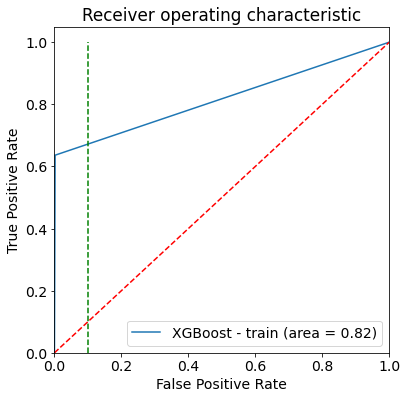

In [55]:
logit_roc_auc = roc_auc_score(y_train, model.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, model.predict(X_train))
auc_train = roc_auc = auc(fpr, tpr)
fig = plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='XGBoost - train (area = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.plot([0.1,0.1],[0,1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

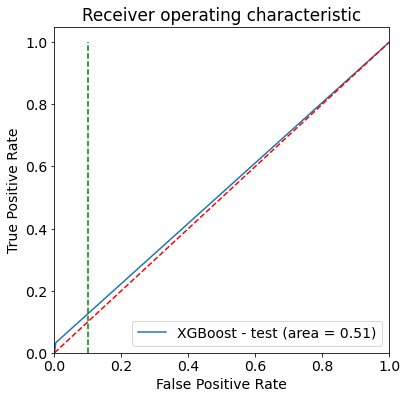

In [56]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
auc_train = roc_auc = auc(fpr, tpr)
fig = plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='XGBoost - test (area = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.plot([0.1,0.1],[0,1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [ ]:
plot_importance(model)
pyplot.figure(figsize = [10,8])
pyplot.show()

In [ ]:
run.complete()

In [ ]:
from azureml.widgets import RunDetails

RunDetails(run).show()

In [ ]:
import json

# Get logged metrics
print("Metrics:")
metrics = run.get_metrics()
for metric_name in metrics:
    print(metric_name, ":", metrics[metric_name])

# Get output files
print("\nFiles:")
files = run.get_file_names()
for file in files:
    print(file)

In [ ]:
run.get_details_with_logs()